
# **LABORATORIO 06**

Utilizando el dataset completo de imagenes generadas por todos los compañeros, aplicar un modelo preentranado para realizar la tarea de deteccion de objetos.

Este trabajo forma parte de la evaluacion de laboratorios y el
segundo parcial. Siendo sujeto a defensa.

NOMBRE: GONZALES SUYO FRANZ REINALDO

DIRECCION DE GITHUB: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-06_CV_Deteccion_objetos

# **Detección de Objetos**

In [ ]:
#importamos las librerias
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random
import timm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET

def cargar_dataset_train(ruta_dataset, ruta_annotations, tamaño_imagen=(50, 50)):
    dataset = []

    # Recorrer las clases en el dataset
    for clase in os.listdir(ruta_dataset):
        ruta_clase = os.path.join(ruta_dataset, clase)
        ruta_clase_annotations = os.path.join(ruta_annotations, clase)

        if os.path.isdir(ruta_clase):
            with os.scandir(ruta_clase) as entries:
                for entry in entries:
                    if entry.is_file() and entry.name.endswith(('.png', '.jpg', '.jpeg')):
                        imagen_ruta = os.path.join(ruta_clase, entry.name)
                        imagen = Image.open(imagen_ruta).convert('RGB')

                        # Preparar la ruta a la anotación correspondiente
                        nombre_base = os.path.splitext(entry.name)[0]
                        archivo_annotation = nombre_base + '.xml'
                        annotation_ruta = os.path.join(ruta_clase_annotations, archivo_annotation)

                        try:
                            etiqueta = parse_xml_annotation(annotation_ruta)
                            # Verificar si la anotación contiene objetos
                            if len(etiqueta['annotation']['object']) > 0:
                                # Verificar si el bounding box es None
                                if all(obj['bndbox'] is not None for obj in etiqueta['annotation']['object']):
                                    # Procesamiento de la imagen
                                    imagen = np.array(imagen) / 255.0
                                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                                    dataset.append((imagen_resized, etiqueta))
                        except FileNotFoundError:
                            print(f"No se encontró la anotación para {entry.name}")
                            continue

    random.shuffle(dataset)
    return dataset

def parse_xml_annotation(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotation = {
        'annotation': {
            'folder': root.find('folder').text,
            'filename': root.find('filename').text,
            'source': {
                'database': root.find('source/database').text,
                'annotation': root.find('source/annotation').text,
                'image': root.find('source/image').text
            },
            'size': {
                'width': root.find('size/width').text,
                'height': root.find('size/height').text,
                'depth': '3'
            },
            'segmented': root.find('segmented').text,
            'object': [{
                'name': obj.find('name').text,
                'pose': obj.find('pose').text if obj.find('pose') is not None else None,
                'truncated': obj.find('truncated').text,
                'occluded': obj.find('occluded').text,
                'bndbox': {'xmin': obj.find('bndbox/xmin').text, 'ymin': obj.find('bndbox/ymin').text, 'xmax': obj.find('bndbox/xmax').text, 'ymax': obj.find('bndbox/ymax').text},
                'difficult': obj.find('difficult').text
            } for obj in root.findall('object')]
        }
    }
    return annotation

# Ejemplo de uso
ruta_dataset = '/content/zip_extraido/Dataset'
ruta_annotations = '/content/zip_extraido/Dataset/Anotaciones'
dataset = cargar_dataset_train(ruta_dataset, ruta_annotations)

FileNotFoundError: [Errno 2] No such file or directory: '/content/zip_extraido/Dataset'

In [ ]:
len(dataset)

In [ ]:
classes =  ['Acelga', 'Espinaca', 'Lechuga', 'Nicotiana_glauca', 'Toronjil']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = dataset[ix]
  # print("+++"*10)
  # print(img)
  # print("..."*10)
  # print(label)
  # print("+++"*10)
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(float(bb['xmin'])), int(float(bb['ymin'])), int(float(bb['xmax'])) - int(float(bb['xmin'])), int(float(bb['ymax'])) - int(float(bb['ymin']))] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns


def plot_anns(img, anns, ax=None, bg=-1, classes=classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height]
  # labels is an array containing the label
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      bb = torch.tensor(bb)
      x, y, w, h = bb.detach().numpy()
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

In [ ]:
img_np, anns = get_sample(5)
plot_anns(img_np, anns)
plt.show()

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

## Descargamos el modelo Pre-Entrenado que es Cascade R-CNN

In [ ]:
# Instalar la versión compatible de torch y torchvision si es necesario
!pip install torch torchvision

In [ ]:
# Instalar Detectron2 en Colab
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-s_p4ci5p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-s_p4ci5p
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done


In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
import torch

# Configuración del dispositivo (usar GPU si está disponible)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configuración del modelo Cascade R-CNN
cfg = get_cfg()
# Corrected path to the config file in model_zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# Corrected function call to get the pre-trained model weights URL
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = device  # Asigna a 'cuda' o 'cpu' según la disponibilidad

# Inicializar el predictor con el modelo configurado
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:08, 20.2MB/s]                           


In [ ]:
# imprimir el modelo
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cpu
  FPN:
    FU

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


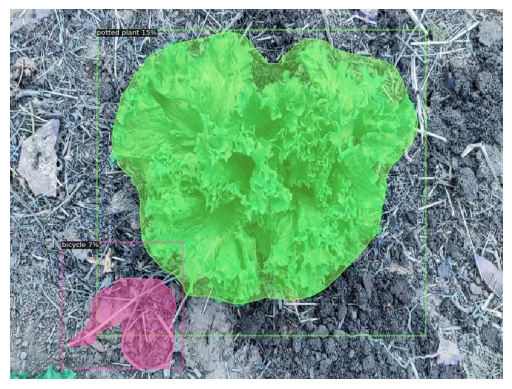

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Cargar una imagen de prueba
image_path = "/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg"  # Reemplaza con la ruta a tu imagen
image = cv2.imread(image_path)

# Realizar la predicción
outputs = predictor(image)

# Visualizar los resultados
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Mostrar la imagen con detecciones
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()


In [ ]:
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html


In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import torch

# Configuración del dispositivo (usar GPU si está disponible)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configuración del modelo Cascade R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))  # Ruta en model_zoo para Cascade R-CNN
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")  # Descarga los pesos pre-entrenados
cfg.MODEL.DEVICE = device  # Configura el dispositivo

# Crea el predictor
predictor = DefaultPredictor(cfg)


model_final_480dd8.pkl: 288MB [00:09, 30.2MB/s]                           


In [ ]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cpu
  FPN:
    FU

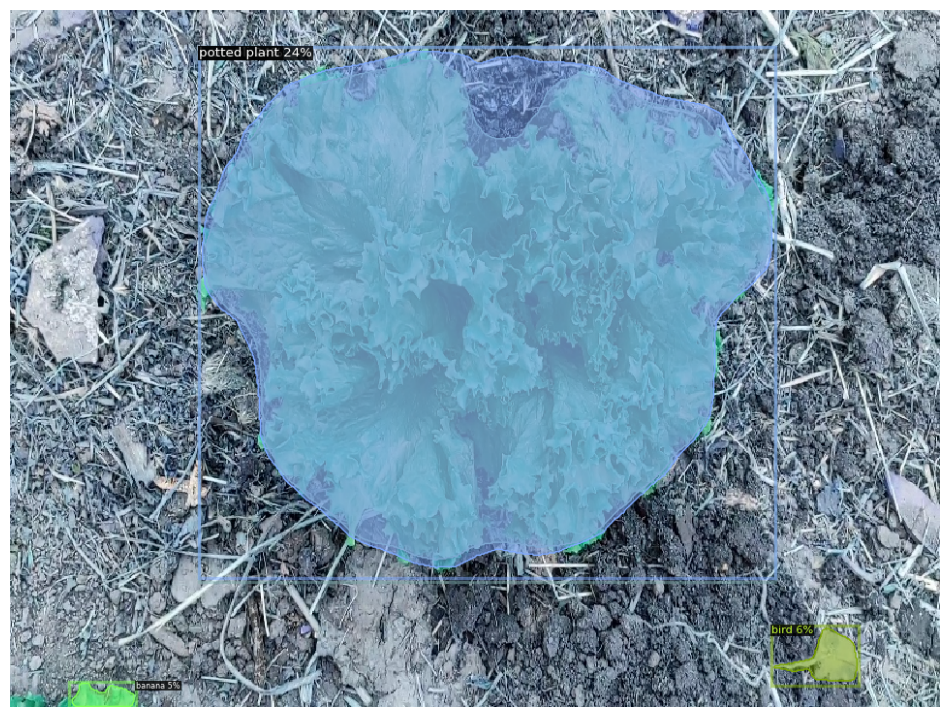

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Cargar imagen de prueba
image = cv2.imread("/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg")  # Cambia "/path/to/your/image.jpg" a la ruta de tu imagen

# Realizar la predicción
outputs = predictor(image)

# Visualizar los resultados
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Mostrar la imagen
plt.figure(figsize=(12, 12))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()
